In [4]:
# Colab setup
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'LLM-Project')
os.chdir(GOOGLE_DRIVE_PATH)

Mounted at /content/drive


In [5]:
! pip -q install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.8 MB/s eta 0:00:00


# DriveLM

In [6]:
import os
from PIL import Image

nuscenes_path = 'DriveLM/data/nuscenes/samples/'

nuscenes = {}

for folder in os.listdir(nuscenes_path):
    folder_path = os.path.join(nuscenes_path, folder)
    if os.path.isdir(folder_path):
        nuscenes[folder] = {}
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            nuscenes[folder][img_name] = Image.open(img_path)


In [7]:
import json
from datasets import Dataset


class DriveLM:
    def __init__(self, json_path="DriveLM/data/QA_dataset_nus/v1_0_train_nus.json"):

        with open(json_path, 'r') as f:
            data = json.load(f)

        examples = []
        for scene_token, scene_data in data.items():
            scene_desc = scene_data.get('scene_description')
            for frame_token, frame_data in scene_data['key_frames'].items():
                image_paths = frame_data.get('image_paths', {})
                for task, qa_list in frame_data['QA'].items():
                    for qa in qa_list:
                        example = {
                            "scene_token": scene_token,
                            "frame_token": frame_token,
                            "scene_description": scene_desc,
                            "task": task,
                            "question": qa.get("Q"),
                            "answer": qa.get("A"),
                            "context": qa.get("C"),
                            "image_paths": image_paths,
                        }
                        examples.append(example)

        self.hf_dataset = Dataset.from_list(examples)

    def __getitem__(self, idx):
      keys = ['scene_description', 'question', 'answer']
      sample = {key: self.hf_dataset[idx][key] for key in keys}

      sample['images'] = {}
      for image_type, image_path in self.hf_dataset[idx]['image_paths'].items():
          image_name = image_path.split('/')[-1]
          sample['images'][image_type] = nuscenes[image_type][image_name]
      return sample

    def __len__(self):
        return len(self.hf_dataset)


dataset = DriveLM()

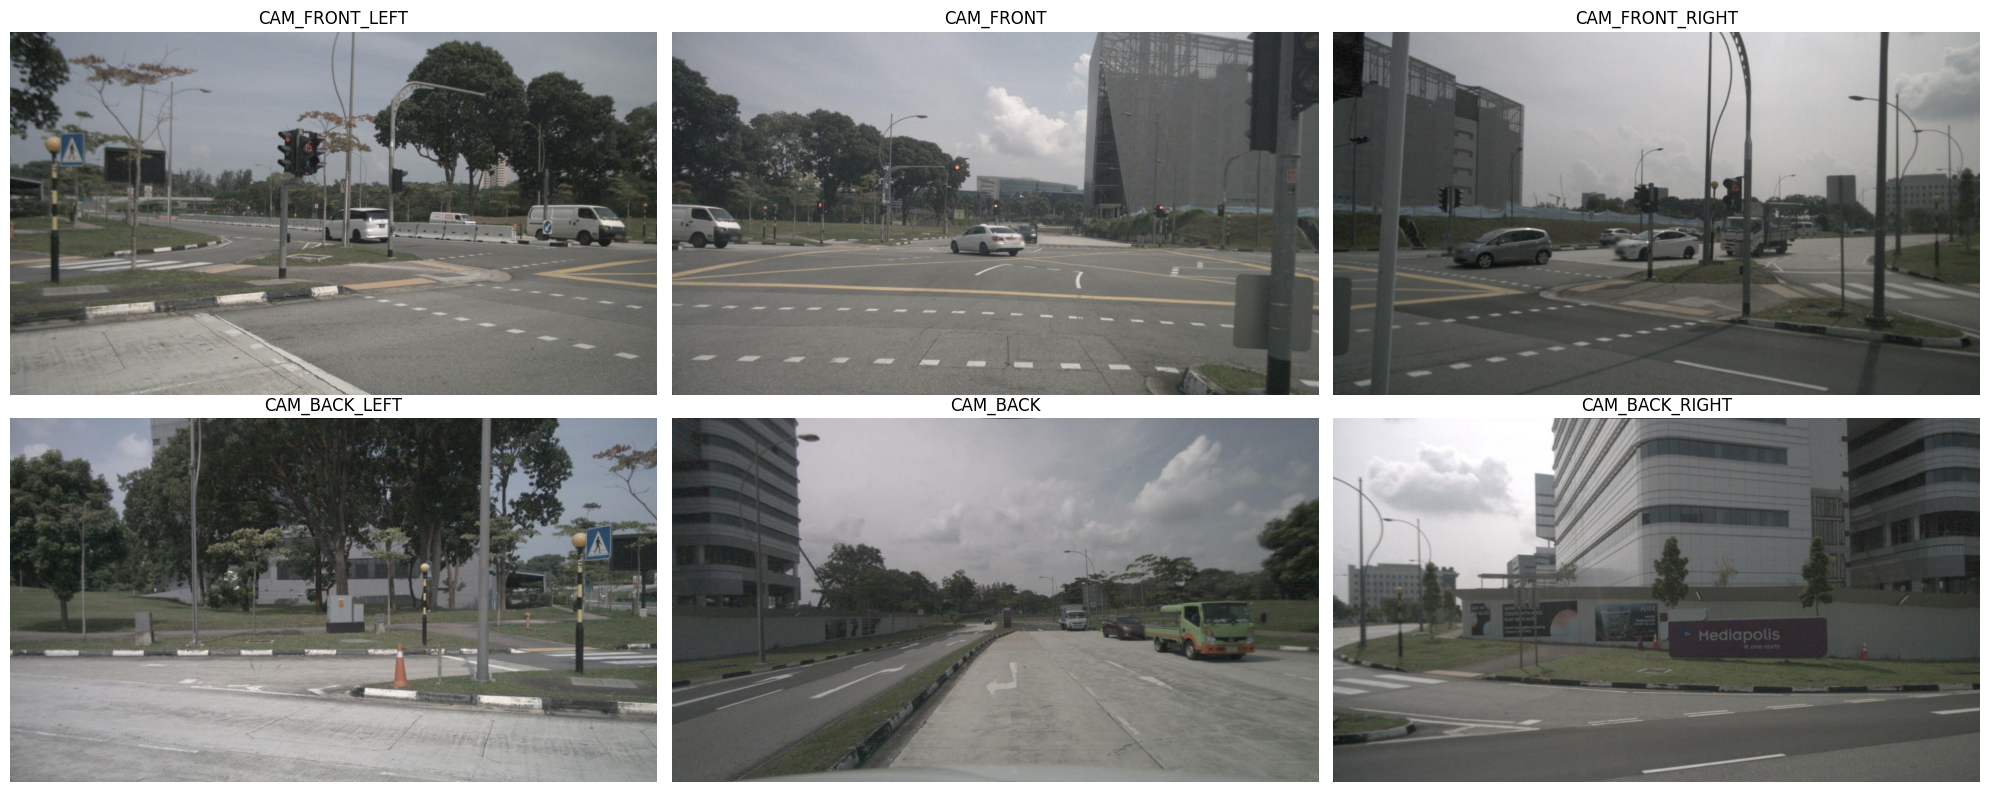

scene_description: The ego vehicle proceeds along the current road, coming to a halt at the traffic light intersection.
question: In this scenario, what are safe actions to take for the ego vehicle?
answer: Brake gently to a stop, slightly offset to the right, and slightly offset to the left.


In [ ]:
import matplotlib.pyplot as plt

index = 510
sample = dataset[index]

def display_image(image, title):
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

plt.figure(figsize=(20, 8))
cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
for i, camera in enumerate(cameras):
    plt.subplot(2, 3, i + 1)
    display_image(sample['images'][camera], camera)
plt.tight_layout()
plt.show()

for key, value in sample.items():
    if type(value) is str:
        print(f"{key}: {value}")

# Llava

In [79]:
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
import torch

model_id = "llava-hf/llava-1.5-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

processor = AutoProcessor.from_pretrained(model_id)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
!wget "https://i.postimg.cc/44hZvX9K/majestic-medieval-castle-stockcake.jpg" -O sample.png
castle_image = Image.open("sample.png")
# castle_image

In [ ]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/b/b6/Felis_catus-cat_on_snow.jpg' -O cat.png
cat_image = Image.open("cat.png")
# cat_image

In [ ]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": cat_image},
            {"type": "image", "image": castle_image},
            {"type": "text", "text": "What is shown in this image?"},
        ],
    },
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, torch.float16)

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=50)
processor.batch_decode(generate_ids, skip_special_tokens=True)

['USER:  \n \nWhat is shown in this image? ASSISTANT: The image shows a large, old castle with a stone wall and a cat walking around it. The castle is situated on a hill, and the cat is exploring the area.']

In [19]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

sample = dataset[510]

cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
user_msg = []
for camera in cameras:
    user_msg.extend([
        {"type": "text", "text": camera},
        {"type": "image", "image": sample["images"][camera]}
    ])
user_msg.append({"type": "text", "text":sample["question"]})

conversation = [
    {
        "role": "user",
        "content": user_msg,
    },
]

sample2 = dataset[210]

cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
user_msg2 = []
for camera in cameras:
    user_msg2.extend([
        {"type": "text", "text": camera},
        {"type": "image", "image": sample2["images"][camera]}
    ])
user_msg2.append({"type": "text", "text":sample2["question"]})

conversation2 = [
    {
        "role": "user",
        "content": user_msg2,
    },
]

inputs = processor.apply_chat_template(
    [conversation, conversation2],
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
    padding=True,
).to(model.device, torch.float16)

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=50)
print(processor.batch_decode(generate_ids, skip_special_tokens=True))

In [ ]:
processor.batch_decode(generate_ids, skip_special_tokens=True)[1]

'USER:  \n \n \n \n \n \nCAM_FRONT_LEFT CAM_FRONT CAM_FRONT_RIGHT CAM_BACK_LEFT CAM_BACK CAM_BACK_RIGHT What kind of traffic sign is <c3,CAM_FRONT,864.5,293.6>? ASSISTANT: The traffic sign is a stop sign.'

In [ ]:
processor.batch_decode(generate_ids, skip_special_tokens=True)[0]

'USER:  \n \n \n \n \n \nCAM_FRONT_LEFT CAM_FRONT CAM_FRONT_RIGHT CAM_BACK_LEFT CAM_BACK CAM_BACK_RIGHT In this scenario, what are safe actions to take for the ego vehicle? ASSISTANT: In this scenario, the ego vehicle is driving down a street with a building in the background. To ensure safety, the driver should maintain a safe distance from other vehicles, pedestrians, and any obstacles on the road. They should'

In [ ]:
inputs['input_ids'].shape

torch.Size([2, 3551])

In [ ]:
print("ground truth:", sample2['answer'])

ground truth: Traffic light.


# Fine-tune

In [80]:
from torch.utils.data import Dataset

class VLMQADataset(Dataset):
    def __init__(self, dataset: DriveLM):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']

        user_msg = []
        for camera in cameras:
            user_msg.extend([
                {"type": "text", "text": camera},
                {"type": "image", "image": item["images"][camera]}
            ])
        user_msg.append({"type": "text", "text":item["question"]})

        conversation = [
            {
                "role": "user",
                "content": user_msg,
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": item["answer"]},
                ],
            }
        ]

        inputs = processor.apply_chat_template(
            conversation,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt"
        ).to(torch.float16)

        return inputs


In [81]:
from peft import prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

In [82]:
from peft import LoraConfig, get_peft_model
from transformers import Trainer, TrainingArguments

peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules="all-linear",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)
peft_model = get_peft_model(model, peft_config)

In [83]:
learning_rate = 1e-5
optimizer = torch.optim.Adam(peft_model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [68]:
peft_model.parameters()

<generator object Module.parameters at 0x79a75ec78c80>

In [84]:
peft_model.print_trainable_parameters()

trainable params: 47,267,840 || all params: 7,110,694,912 || trainable%: 0.6647


In [85]:
from torch.utils.data import DataLoader


epochs = 3
train_dataset = VLMQADataset(dataset)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
for epoch in range(epochs):
    peft_model.train()
    total_loss = 0.0
    for batch in train_dataset:
        batch = batch.to(peft_model.device)
        optimizer.zero_grad()
        outputs = peft_model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 150.12 MiB is free. Process 10344 has 14.59 GiB memory in use. Of the allocated memory 13.47 GiB is allocated by PyTorch, and 1023.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [91]:
import torch
import gc

# Delete tensor
# del model, processor, optimizer

# Run garbage collection

# Empty CUDA cache (to release memory back to the system)
torch.cuda.empty_cache()
gc.collect()


0

In [98]:
torch.stack([train_dataset[0]['pixel_values']]).shape

torch.Size([1, 6, 3, 336, 336])

In [99]:
train_dataset = VLMQADataset(dataset)

training_args = TrainingArguments(
    output_dir="./checkpoints",
    per_device_train_batch_size=1,
    num_train_epochs=1,
    learning_rate=2e-5,
    logging_steps=20,
    save_steps=200,
    bf16=True,
    report_to="none",
)

def data_collator(features):
    return features[0]
    # Collate input_ids, attention_mask, labels, pixel_values, etc.
    # print(features)
    # batch = {}
    # for key in features[0]:
    #     if key == "pixel_values":
    #         batch
    #     else:
    #         batch[key] = torch.stack([f[key] for f in features])
    # return batch

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.56 GiB. GPU 0 has a total capacity of 14.74 GiB of which 370.12 MiB is free. Process 10344 has 14.38 GiB memory in use. Of the allocated memory 13.48 GiB is allocated by PyTorch, and 785.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)